# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by
Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* An additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment
each method limitations and/or advantages.

### 1.1 Brain image visualization

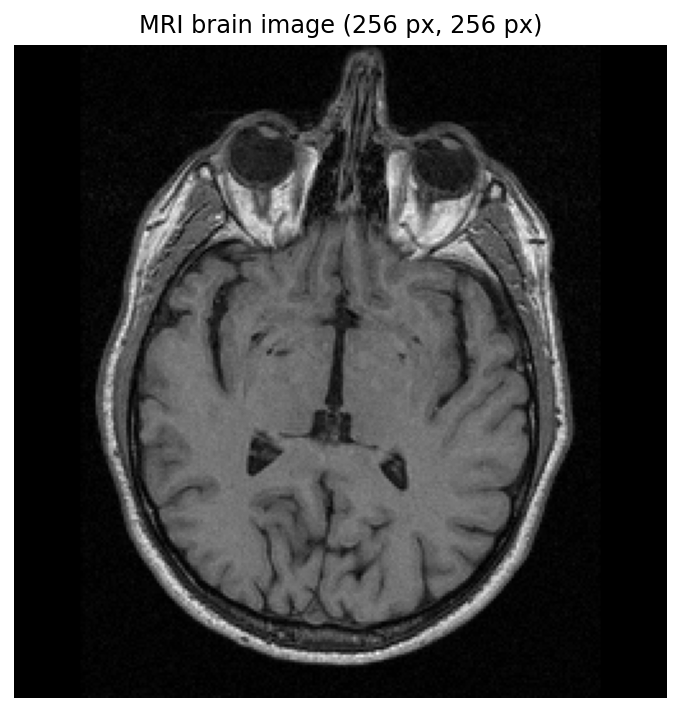

In [2]:
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

Algorithm for Region growing:
* Fix a starting point
* define the homogeneity criterion used to define the region
* include all the neighboring pixels, that satisfy the homogeneity criterion.

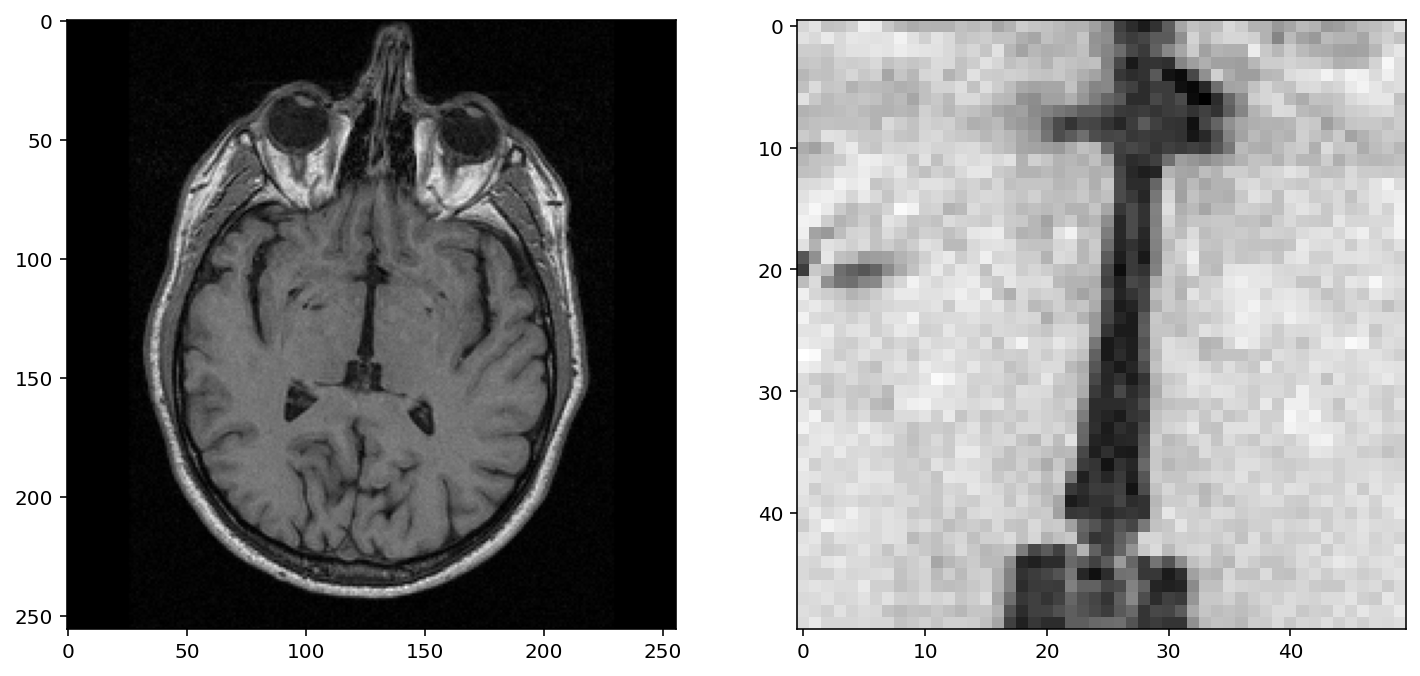

In [3]:
#Find a criterion (i.e. find a threshold)
brain_im_small = brain_im[100:150,100:150]

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].imshow(brain_im, cmap='gray')
ax[1].imshow(brain_im_small, cmap='gray')
plt.show()

In [4]:
print(np.min(brain_im_small),np.max(brain_im_small))
# We find the minimum and maxmum value in a certain (ramdom) field in the brain and use it as threshhold

3 95


In [5]:
# Add your implementation and discussion
def region_growing(im, x,y, thresh_low,thresh_high):
    '''takes an image and a starting point nd grows the region that sitzs inbetween the threshhold.
    returns a mask with true values in the segmentation'''
    
    eightneig = [(-1,-1),(0,-1),(-1,0),(1,0),(0,1),(-1,1),(1,-1),(1,1)]
    
    seg = np.zeros(shape = im.shape, dtype = np.uint8)
    visited = np.zeros(shape = im.shape, dtype = np.uint8)
    
    seg[x][y] = 1
    
    seeds = [(x,y)]
    
    
    while len(seeds):
        seed = seeds.pop(0)
        x = seed[0]
        y = seed[1]
        
        visited[x][y] = 1
        for direct in eightneig:
            cur_x = x + direct[0]
            cur_y = y + direct[1]
            #print(f'visited of current point = {visited[cur_x][cur_y]}, and the image value = {im[cur_x,cur_y]}')
            if cur_x < 0 or cur_y < 0 or cur_y > im.shape[1] or cur_x > im.shape[0]:
                continue
            if visited[cur_x][cur_y]==0 and (thresh_low <= im[cur_x,cur_y] <= thresh_high):
                #print(f'cur_x = {cur_x} and cur_y = {cur_y}')
                seg[cur_x][cur_y] = 1
                visited[cur_x][cur_y] = 1
                seeds.append((cur_x,cur_y))
    
    return(seg)

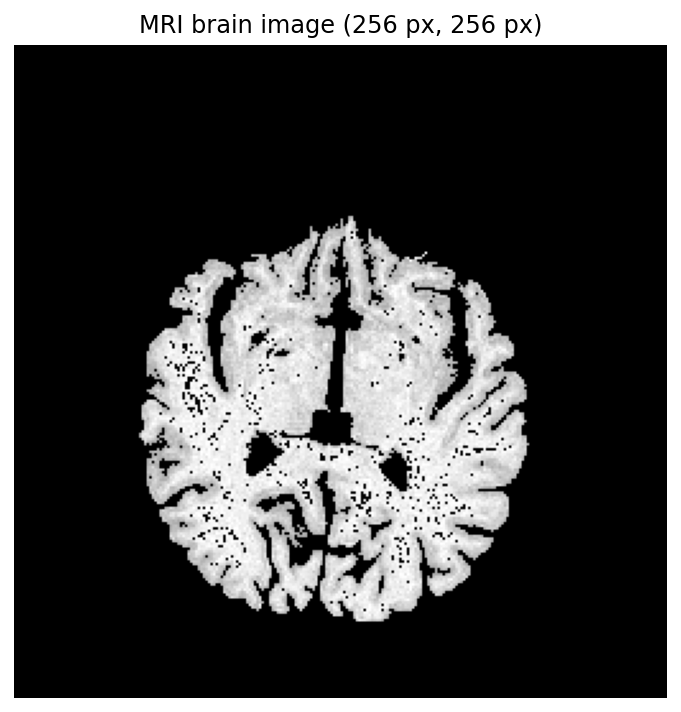

In [6]:
mask = region_growing(brain_im,100,100,60,90)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im*mask, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

As we see some black points, we will put the threshhold a little bit higher.

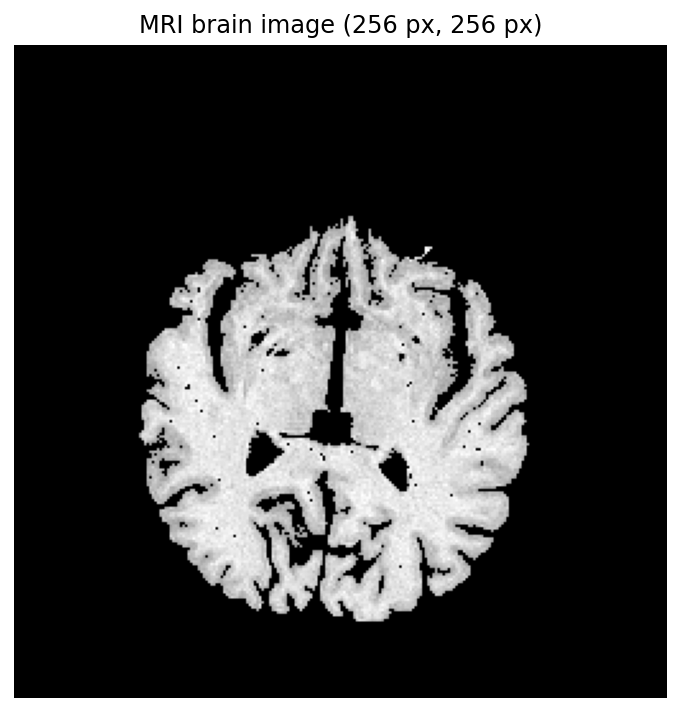

In [7]:
mask = region_growing(brain_im,100,100,60,95)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im*mask, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

To sum up the pixels in the brain, we sum up the ones in our segmentatioin matrix:

In [8]:
print(f'The number of pixels in the brain is:', np.sum(mask))

The number of pixels in the brain is: 15354


#### Advanteges of the method:


#### Disadvantages of the method:
* We find great differences in our region if we the change the threshhold a little bit
* Also, the threshhold is very perticular for this special image and must not be applyable to other images (een MRI images of brains)

### 1.3 Contour detection (5pts)

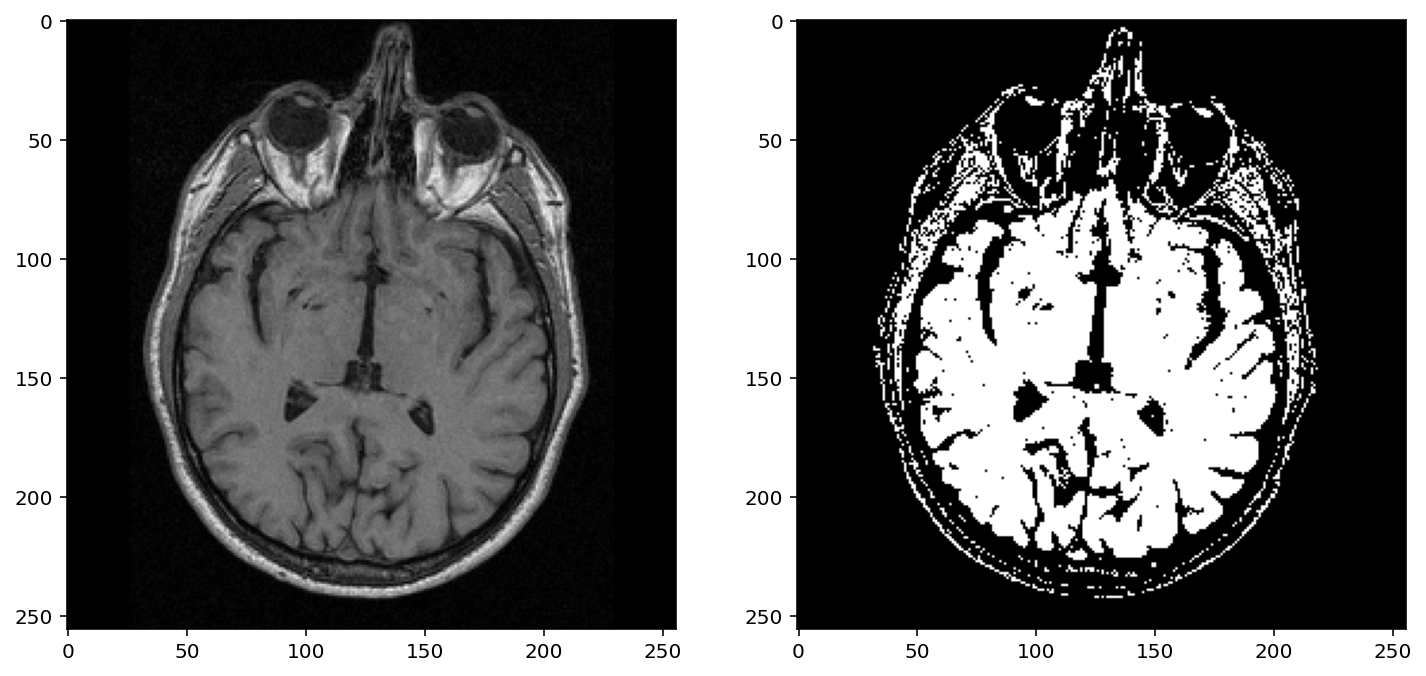

In [9]:
import numpy as np
mask_brain=(brain_im>60)&(brain_im<95)
not_brain=np.logical_not(mask_brain)

new_im_brain = np.copy(brain_im)
new_im_brain[mask_brain] = 255
new_im_brain[not_brain] = 0
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
#ax[0].imshow(brain_im)
#ax[1].imshow(new_im_brain)
ax[0].imshow(brain_im, cmap='gray')
ax[1].imshow(new_im_brain, cmap='gray')
plt.show()

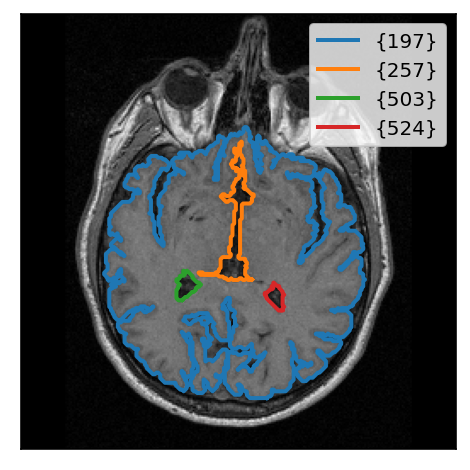

In [27]:
from skimage import measure

# Find contours at a constant value of 0.8
contours = measure.find_contours(new_im_brain, 60)

#make a list of the longest 10 contours and their indices in the list contours
list_shapes = [[contour.shape[0],i] for i,contour in enumerate(contours)]
sortet_list = sorted(list_shapes,key=lambda x: x[0])[:-20:-1]
sortet_list = [int(x[1]) for x in sortet_list]

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(brain_im, cmap=plt.cm.gray)

for i,contour in enumerate(contours):
    if i in [197,257,524,503]:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2,label = {i})
    

plt.legend()
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()


We extracted the contours relevant to us (by finding indices by hand). Now we want to find all the pixels, that are inside the contours we found, starting by a seed point.

In [38]:
rel_contours =[contours[i] for i in [197,257,524,503]]
#rel_contours

In [40]:
import cv2

# Initialize empty list
lst_intensities = []

# For each list of contour points...
for i in range(len(rel_contours)):
    # Create a mask image that contains the contour filled in
    cimg = np.zeros_like(brain_im)
    cv2.drawContours(cimg, rel_contours, i, color=255, thickness=-1)

    # Access the image pixels and create a 1D numpy array then add to list
    pts = np.where(cimg == 255)
    lst_intensities.append(brain_im[pts[0], pts[1]])

error: OpenCV(4.3.0) /io/opencv/modules/imgproc/src/drawing.cpp:2480: error: (-215:Assertion failed) npoints > 0 in function 'drawContours'


In [0]:
fig, ax = plt.subplots()
ax.imshow(brain_im, cmap=plt.cm.gray)

ax.plot(contours[197][:, 1], contours[197][:, 0], linewidth=2)


ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [0]:
print(contours[197])

### 1.4 Additional method (5pts)

In [0]:
# Add your implementation and discussion

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

### 2.1 Visualization

In [0]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

In [0]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

In [0]:
# Add your implementation and discussion

### 2.3 Total area (in pixels) of each color (5 pts)

In [0]:
# Add your implementation and discussion